<a href="https://colab.research.google.com/github/zimin205/BDA_Data/blob/main/LR_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lifelines xgboost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Bold,나눔스퀘어라운드 Bold:style=Bold,Regular
/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf: NanumGothicCoding,나눔고딕코딩:style=Bold
/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Regular,나눔스퀘어라운드 Regular:style=Regular
/usr/share/fonts/truetype/nanum/NanumSquareB.ttf: NanumSquare,나눔스퀘어,NanumSquare Bold,나눔스퀘어 Bold:style=Bold
/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf: NanumBarunGothic,나눔바른고딕:style=Regular
/usr/share/fonts/truetype/n

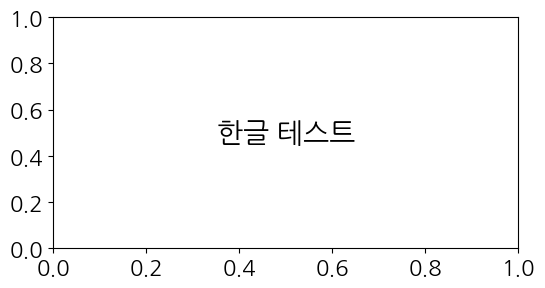

In [ ]:
# %% [code]
# 1️⃣ NanumGothic 폰트 설치
!apt-get update -qq
!apt-get install -y fonts-nanum

# 2️⃣ Matplotlib에서 폰트 캐시를 갱신
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 한글 폰트 경로 확인 (설치된 폰트 목록 확인)
!fc-list :lang=ko | grep Nanum

# 3️⃣ Matplotlib에서 사용할 폰트 경로 지정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# 4️⃣ 폰트 적용
fm.fontManager.addfont(font_path)  # 폰트 매니저에 추가
plt.rcParams['font.family'] = ['NanumGothic', 'DejaVu Sans']


# 5️⃣ Matplotlib 폰트 캐시 삭제 후 강제 갱신
!rm -rf ~/.cache/matplotlib
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 6️⃣ 폰트 적용 테스트 (한글 출력 확인)
plt.figure(figsize=(6,3))
plt.text(0.5, 0.5, "한글 테스트", fontsize=20, ha='center', va='center')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from lifelines.utils import concordance_index


# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/BDA 6기 운영진/6기 데이터팀/김지민/df.csv')
exclude_columns = [
    'member_name','identifier','시도','idea_binary',
    'proficiency_sql','proficiency_matlab','proficiency_python','proficiency_r','proficiency_c','proficiency_c++','proficiency_c#',
    'proficiency_js','proficiency_java','proficiency_pandas','proficiency_numpy','proficiency_sklearn','proficiency_pytorch',
    'proficiency_tenserflow','proficiency_keras','proficiency_looker','proficiency_tableau','proficiency_bi','proficiency_google',
    'proficiency_python_library',
    'desired_job_software','expected_domain_service','project_type_팀',
    'school_휴학','job_대학생','job_대학원생','job_직장인','job_취준생',
    'academic_background_고등학교 졸업','academic_background_대학교','academic_background_대학원 석사',
    'dropout_week'
]
df = df.loc[:, ~df.T.duplicated()]
df.drop(columns=[col for col in exclude_columns if col in df.columns], inplace=True)
df.dropna(inplace=True)

# object → category
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

# event & stop_time 정의
df['event'] = df['dropout']
df['stop_time'] = df['class_week']

# 클래스 비율
pos_weight = (df['dropout'] == 0).sum() / (df['dropout'] == 1).sum()

# 모델 정의
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True,
                             scale_pos_weight=pos_weight, random_state=42)
}

# ========================
# 1. Train/Test Split 평가
# ========================
print("🔹 Train/Test Split 성능")
X = df.drop(columns=['dropout', 'member_id', 'class_week', 'event', 'stop_time'])
y = df['dropout']
stop_time = df['stop_time']
event = df['event']

X_train, X_test, y_train, y_test, stop_train, stop_test, event_train, event_test = train_test_split(
    X, y, stop_time, event, test_size=0.1, random_state=42, stratify=y
)

split_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    split_results.append({
        "Model": name,
        "F1-score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba),
        "Accuracy": accuracy_score(y_test, y_pred),
        "C-index": concordance_index(stop_test, -y_proba, event_test)
    })
split_df = pd.DataFrame(split_results)
split_df = split_df.round(4)
display(split_df)
# ============================
# 2. Stratified 10-Fold 평가
# ============================
print("\n🔹 Stratified 10-Fold 성능")
id_event_df = df[['member_id', 'dropout']].drop_duplicates()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_results = {name: {'F1': [], 'AUC': [], 'ACC': [], 'CIDX': []} for name in models}

for name, model in models.items():
    for train_idx, test_idx in skf.split(id_event_df['member_id'], id_event_df['dropout']):
        train_ids = id_event_df.iloc[train_idx]['member_id']
        test_ids = id_event_df.iloc[test_idx]['member_id']

        train_data = df[df['member_id'].isin(train_ids)]
        test_data = df[df['member_id'].isin(test_ids)]

        X_train = train_data.drop(columns=['dropout', 'member_id', 'class_week', 'event', 'stop_time'])
        y_train = train_data['dropout']
        X_test = test_data.drop(columns=['dropout', 'member_id', 'class_week', 'event', 'stop_time'])
        y_test = test_data['dropout']
        stop_test = test_data['stop_time']
        event_test = test_data['event']

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        cv_results[name]['F1'].append(f1_score(y_test, y_pred))
        cv_results[name]['AUC'].append(roc_auc_score(y_test, y_proba))
        cv_results[name]['ACC'].append(accuracy_score(y_test, y_pred))
        cv_results[name]['CIDX'].append(concordance_index(stop_test, -y_proba, event_test))

cv_summary = []
for name in models:
    cv_summary.append({
        "Model": name,
        "F1-score": np.mean(cv_results[name]['F1']),
        "AUC": np.mean(cv_results[name]['AUC']),
        "Accuracy": np.mean(cv_results[name]['ACC']),
        "C-index": np.mean(cv_results[name]['CIDX'])
    })
cv_df = pd.DataFrame(cv_summary)
cv_df = cv_df.round(4)
display(cv_df)

🔹 Train/Test Split 성능


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:12:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,F1-score,AUC,Accuracy,C-index
0,Logistic Regression,0.2899,0.8863,0.7735,0.8726
1,Decision Tree,0.0167,0.4463,0.8182,0.4613
2,XGBoost,0.0769,0.7973,0.8151,0.8079



🔹 Stratified 10-Fold 성능


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:12:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:12:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:12:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:12:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:12:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

,Model,F1-score,AUC,Accuracy,C-index
0,Logistic Regression,0.3729,0.8872,0.7726,0.8524
1,Decision Tree,0.4491,0.9214,0.8224,0.9097
2,XGBoost,0.4596,0.9339,0.8281,0.9299


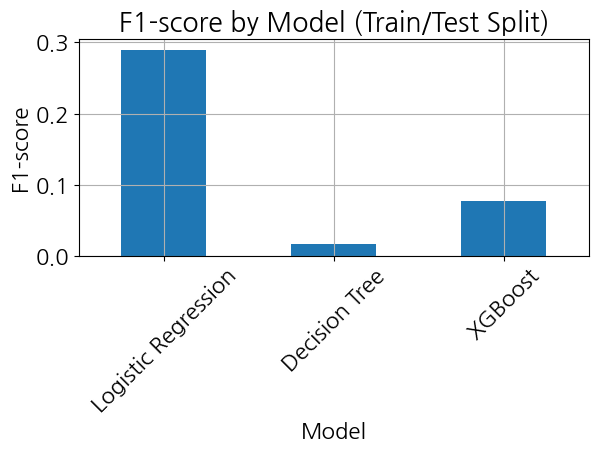

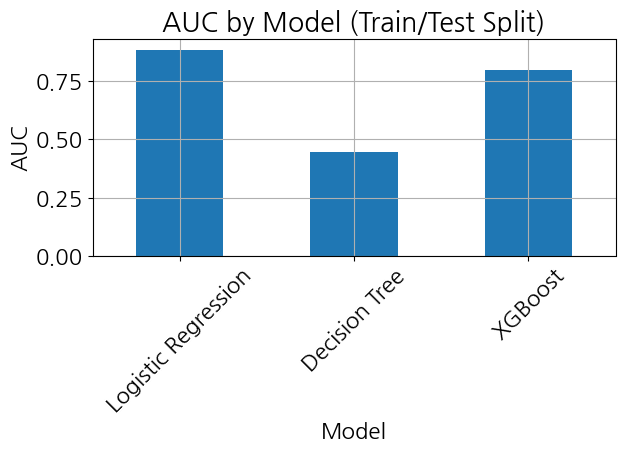

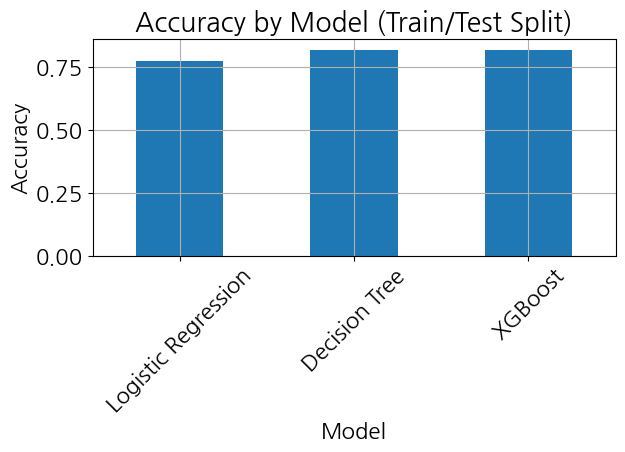

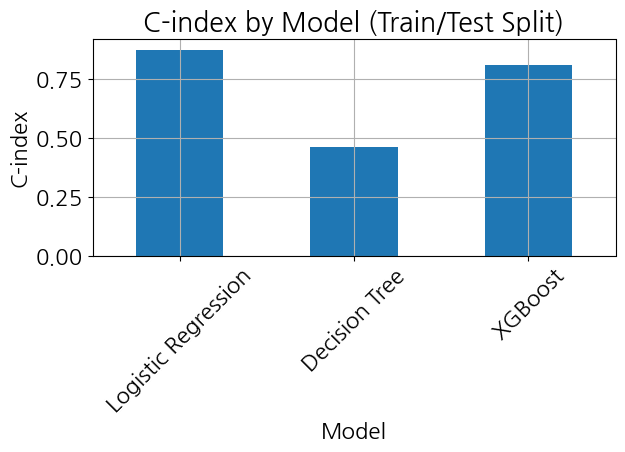

In [ ]:
metrics = ['F1-score', 'AUC', 'Accuracy', 'C-index']
for metric in metrics:
    split_df.plot(kind='bar', x='Model', y=metric, legend=False)
    plt.title(metric + ' by Model (Train/Test Split)')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


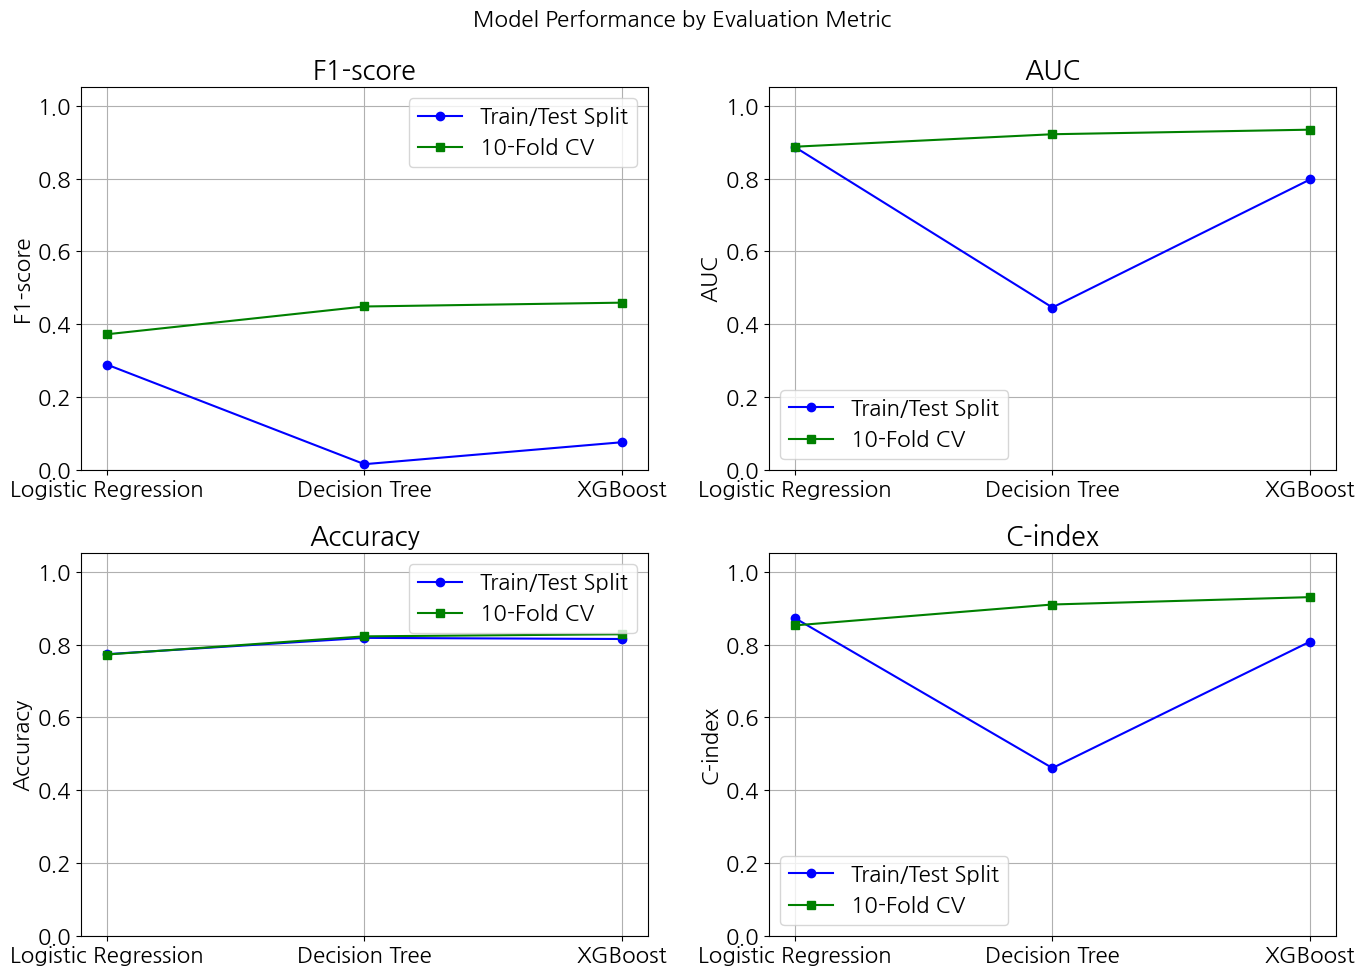

In [ ]:
import matplotlib.pyplot as plt

# 결과 데이터
models = ['Logistic Regression', 'Decision Tree', 'XGBoost']
split_metrics = [
    [0.2899, 0.8863, 0.7735, 0.8726],
    [0.0167, 0.4463, 0.8182, 0.4613],
    [0.0769, 0.7973, 0.8151, 0.8079]
]
cv_metrics = [
    [0.3729, 0.8872, 0.7726, 0.8524],
    [0.4491, 0.9214, 0.8224, 0.9097],
    [0.4596, 0.9339, 0.8281, 0.9299]
]
metric_names = ['F1-score', 'AUC', 'Accuracy', 'C-index']

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for idx, ax in enumerate(axes.flat):
    metric = metric_names[idx]
    split_vals = [m[idx] for m in split_metrics]
    cv_vals = [m[idx] for m in cv_metrics]

    ax.plot(models, split_vals, marker='o', label='Train/Test Split', color='blue')
    ax.plot(models, cv_vals, marker='s', label='10-Fold CV', color='green')
    ax.set_title(metric)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend()

plt.suptitle("Model Performance by Evaluation Metric", fontsize=16)
plt.tight_layout()
plt.show()


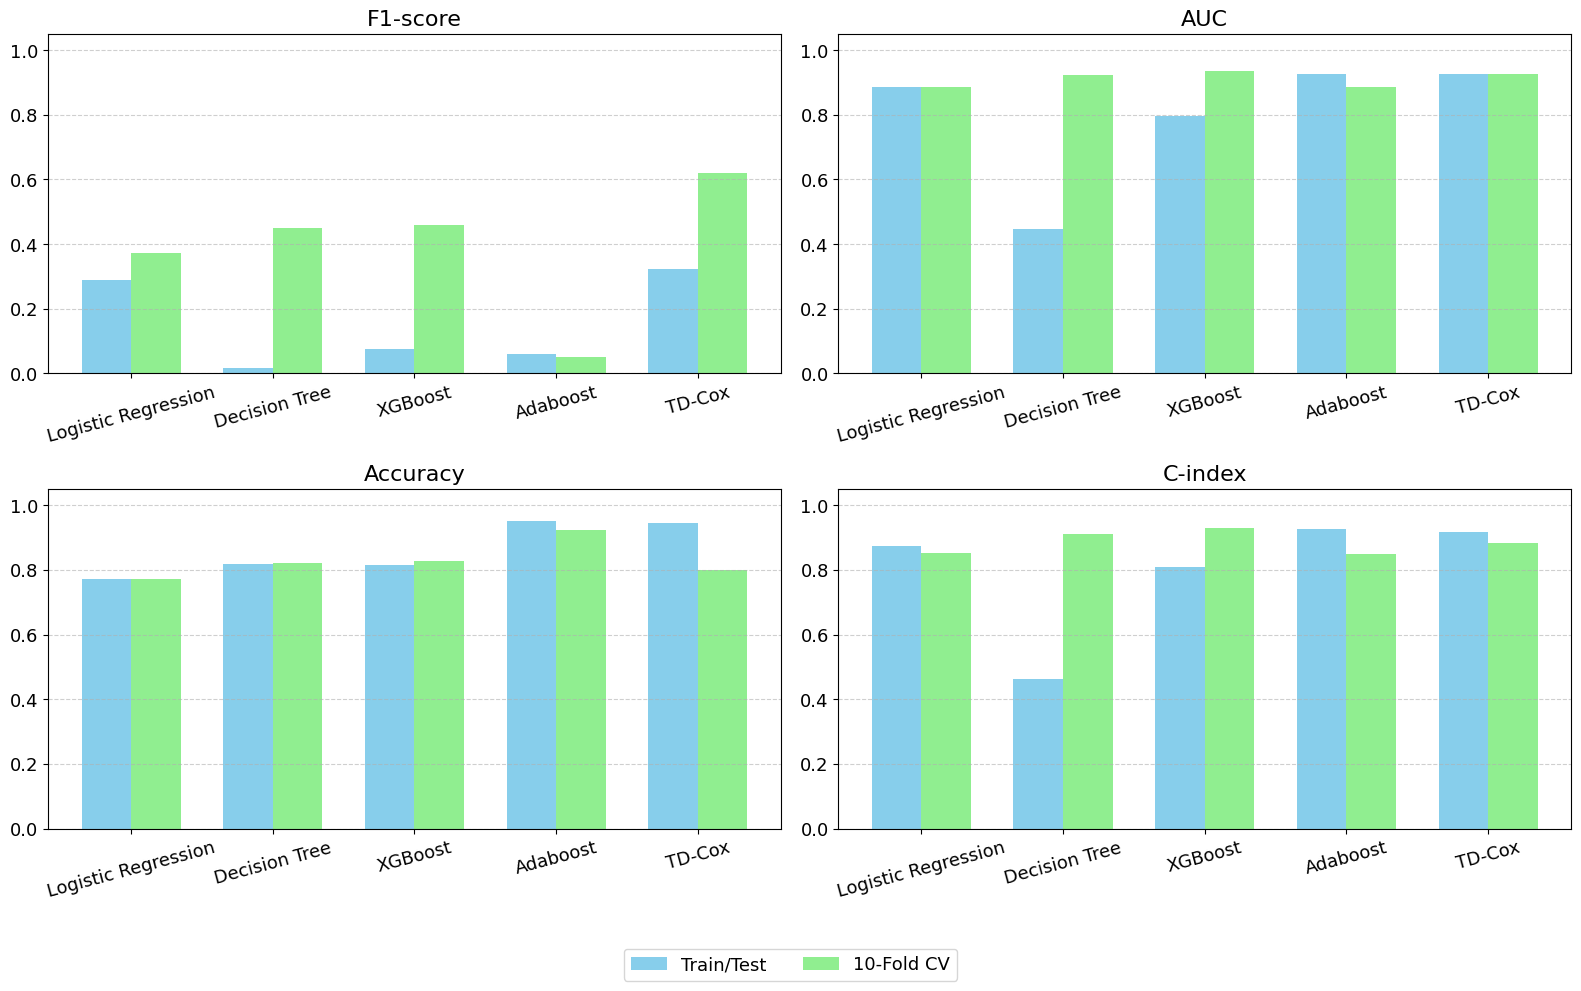

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 📌 폰트 설정 (한글 깨짐 방지용)

plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = 'FreeSerif'

# 모델 이름
labels = ['Logistic Regression', 'Decision Tree', 'XGBoost', 'Adaboost', 'TD-Cox']
x = np.arange(len(labels))
width = 0.35

# 🔹 Train/Test Split 성능
split_scores = {
    'F1-score': [0.2899, 0.0167, 0.0769, 0.0588, 0.3218],
    'AUC': [0.8863, 0.4463, 0.7973, 0.9255, 0.9266],
    'Accuracy': [0.7735, 0.8182, 0.8151, 0.9525, 0.9449],
    'C-index': [0.8726, 0.4613, 0.8079, 0.9255, 0.9186]
}

# 🔹 10-Fold Cross Validation 성능
cv_scores = {
    'F1-score': [0.3729, 0.4491, 0.4596, 0.0503, 0.6198],
    'AUC': [0.8872, 0.9214, 0.9339, 0.8868, 0.9252],
    'Accuracy': [0.7726, 0.8224, 0.8281, 0.9243, 0.8003],
    'C-index': [0.8524, 0.9097, 0.9299, 0.8499, 0.8822]
}

# 📊 2x2 subplot 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
metric_names = ['F1-score', 'AUC', 'Accuracy', 'C-index']

for idx, ax in enumerate(axes.flat):
    metric = metric_names[idx]
    ax.bar(x - width/2, split_scores[metric], width, label='Train/Test', color='skyblue')
    ax.bar(x + width/2, cv_scores[metric], width, label='10-Fold CV', color='lightgreen')
    ax.set_title(metric, fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=15, fontsize=13)
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# ✅ 범례 아래쪽 중앙으로 이동
fig.legend(['Train/Test', '10-Fold CV'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02), fontsize=13)


plt.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.show()


In [ ]:
print(plt.rcParams['font.family'])

['FreeSerif']


Saving times.ttf to times (2).ttf


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50756 (\N{HANGUL SYLLABLE WAN}) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47308 (\N{HANGUL SYLLABLE RYO}) missing from font(s) Times New Roman.
  fig.canvas.print_figu

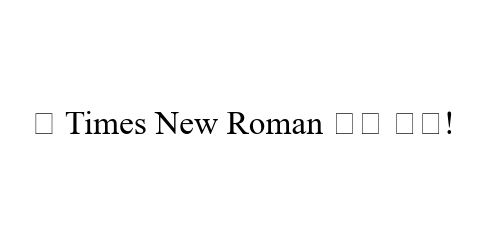

In [ ]:
# 📦 1. 업로드 (Colab 왼쪽 파일탭에서 또는 아래 코드로 업로드)
from google.colab import files
uploaded = files.upload()  # 여기서 times.ttf 업로드

# 📍 2. 업로드한 파일명 확인
font_path = list(uploaded.keys())[0]

# 🧠 3. Matplotlib에 적용
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()  # 전역 기본 폰트 설정

# ✅ 4. 테스트
plt.figure(figsize=(6, 3))
plt.text(0.5, 0.5, '✅ Times New Roman 적용 완료!', fontsize=24,
         ha='center', va='center', fontproperties=font_prop)
plt.axis('off')
plt.show()


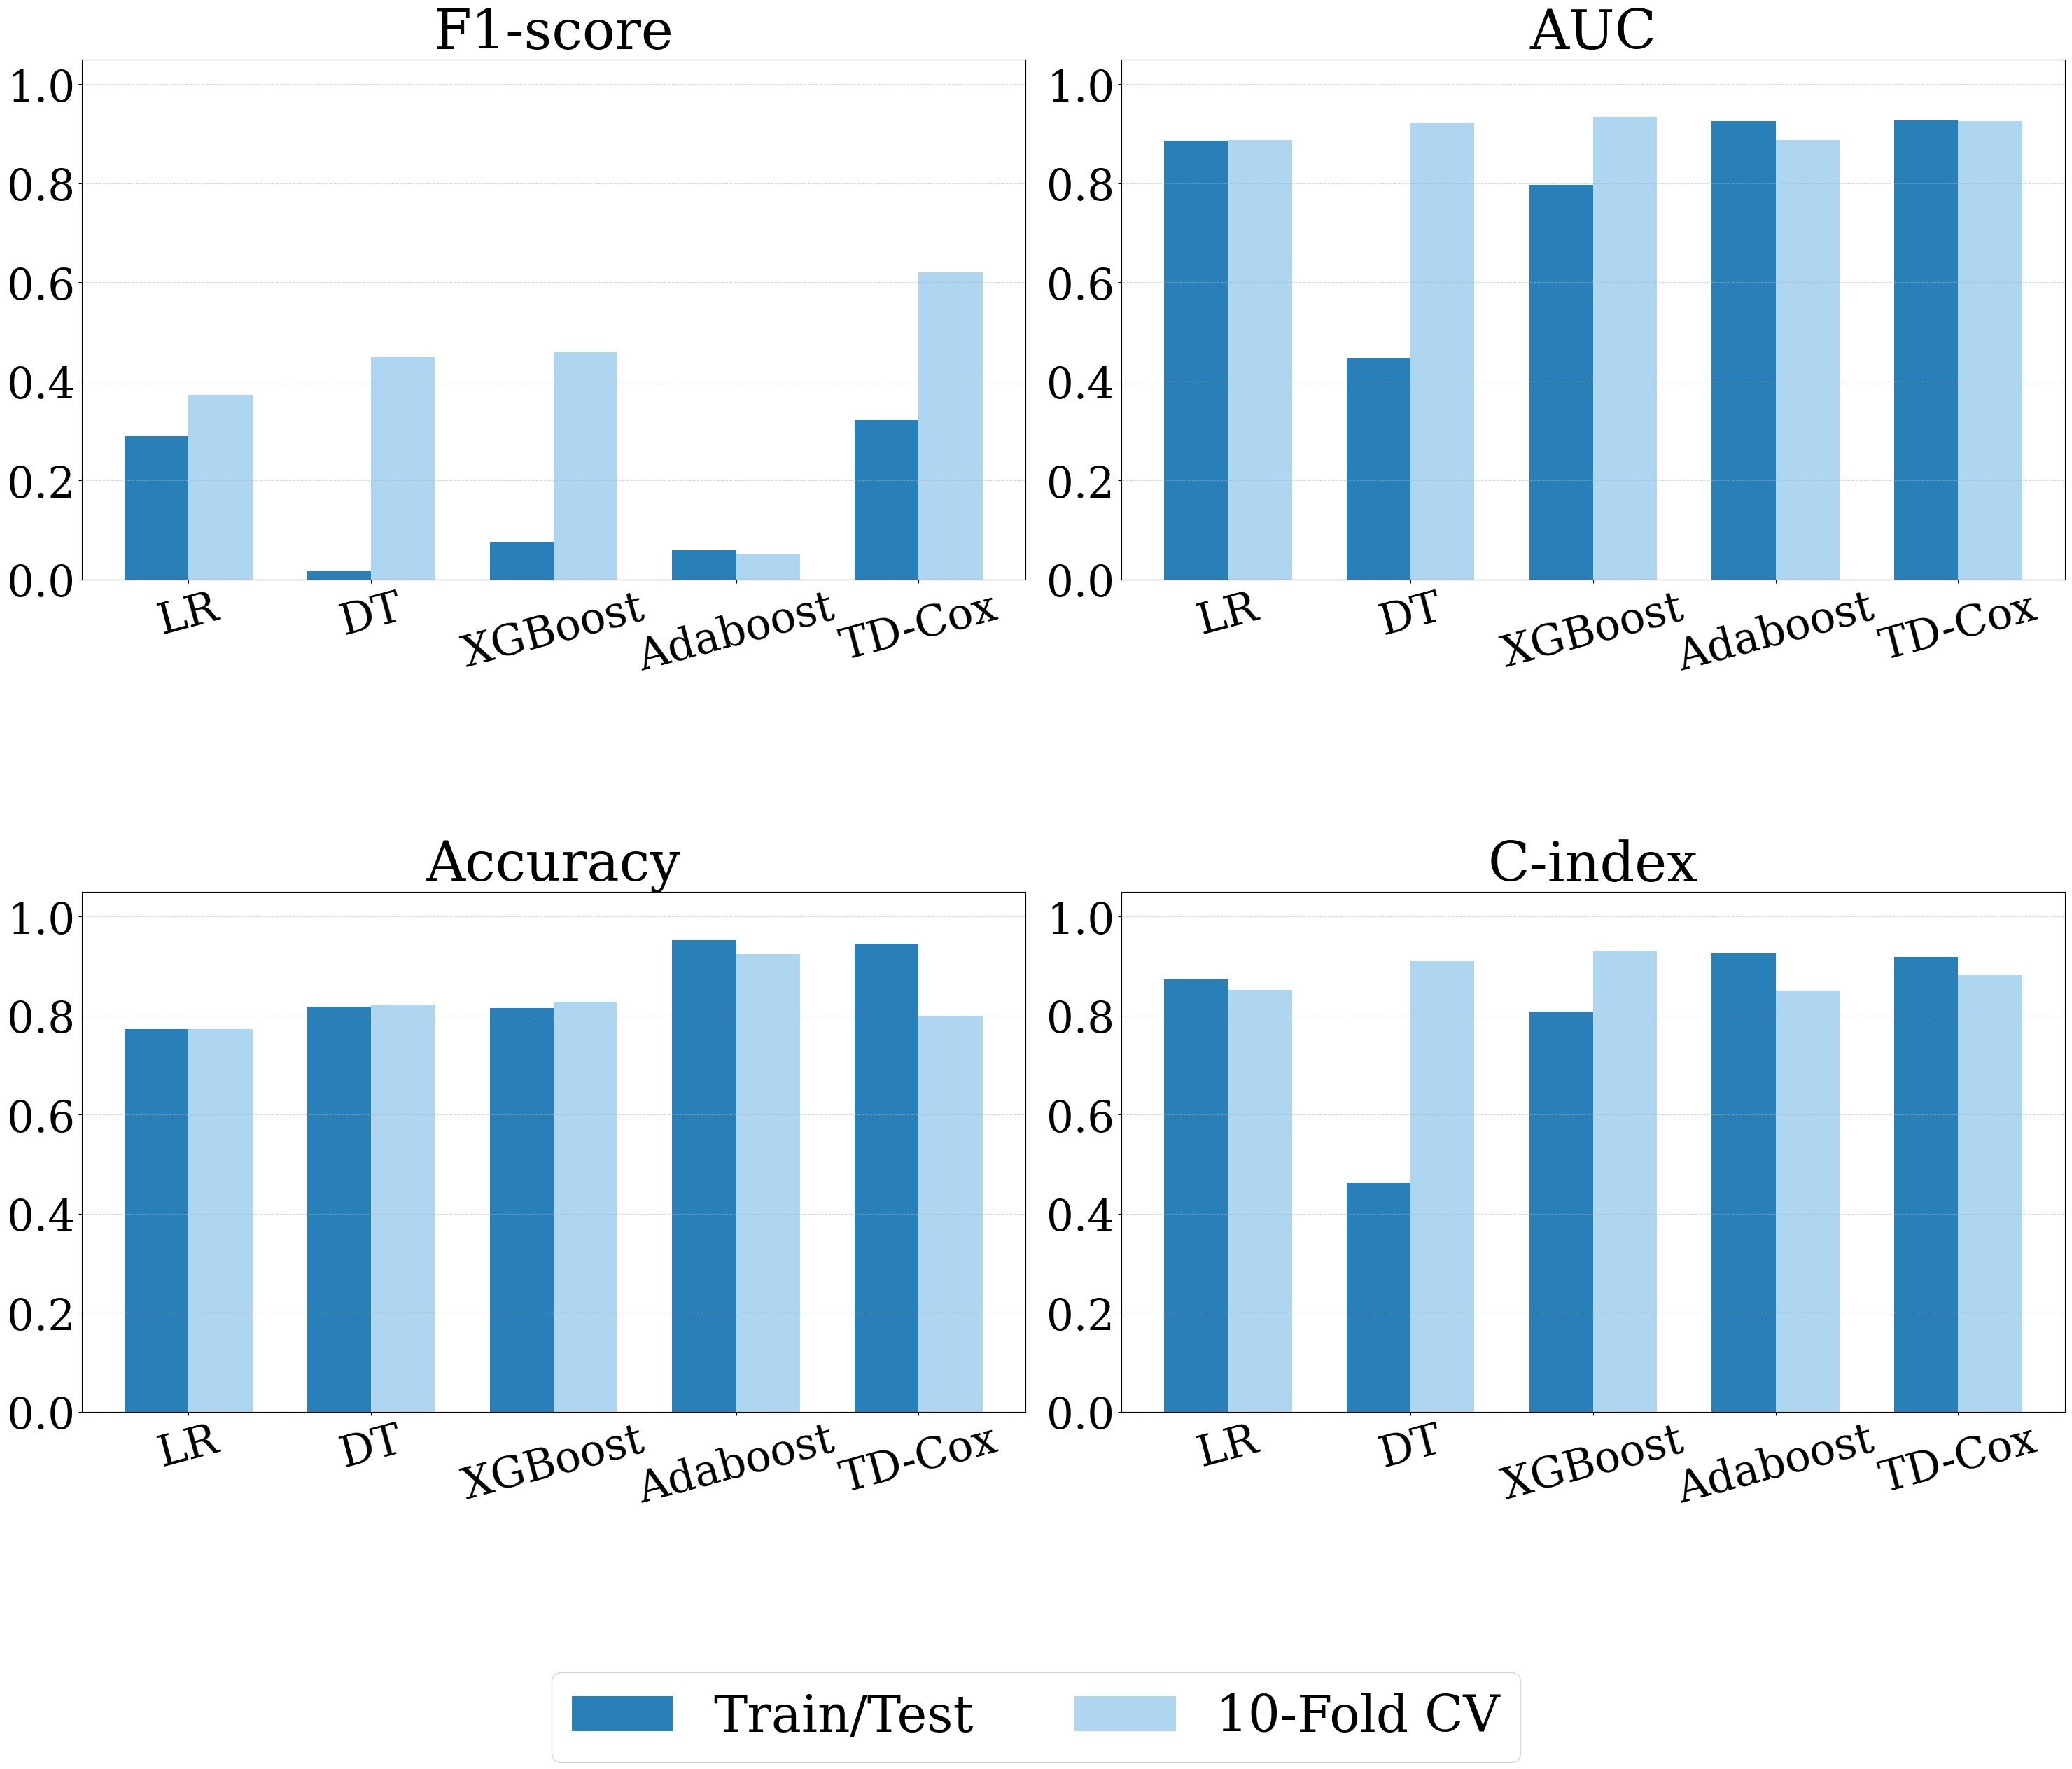

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# 📌 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 20
mpl.rcParams['font.size'] = 20

# 모델 이름 축약
labels = ['LR', 'DT', 'XGBoost', 'Adaboost', 'TD-Cox']
x = np.arange(len(labels))
width = 0.35

# 성능 지표
split_scores = {
    'F1-score': [0.2899, 0.0167, 0.0769, 0.0588, 0.3218],
    'AUC': [0.8863, 0.4463, 0.7973, 0.9255, 0.9266],
    'Accuracy': [0.7735, 0.8182, 0.8151, 0.9525, 0.9449],
    'C-index': [0.8726, 0.4613, 0.8079, 0.9255, 0.9186]
}

cv_scores = {
    'F1-score': [0.3729, 0.4491, 0.4596, 0.0503, 0.6198],
    'AUC': [0.8872, 0.9214, 0.9339, 0.8868, 0.9252],
    'Accuracy': [0.7726, 0.8224, 0.8281, 0.9243, 0.8003],
    'C-index': [0.8524, 0.9097, 0.9299, 0.8499, 0.8822]
}

# 🎨 색상 설정
color_split = '#2980b9'  # 딥블루
color_cv = '#aed6f1'     # 연블루

# 📊 시각화
fig, axes = plt.subplots(2, 2, figsize=(30, 26))  # 그래프 전체 크기
metric_names = ['F1-score', 'AUC', 'Accuracy', 'C-index']

for idx, ax in enumerate(axes.flat):
    metric = metric_names[idx]
    ax.bar(x - width/2, split_scores[metric], width, label='Train/Test', color=color_split)
    ax.bar(x + width/2, cv_scores[metric], width, label='10-Fold CV', color=color_cv)

    ax.set_title(metric, fontsize=56)  # 🔠 제목 크게
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=15, fontsize=44)  # 🔠 x축 글자 크게
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(axis='y', labelsize=44)  # 🔠 y축 눈금도 크게

# ✅ 범례 크고 간격 조정
fig.legend(['Train/Test', '10-Fold CV'],
           loc='lower center',
           ncol=2,
           bbox_to_anchor=(0.5, -0.02),  # 🔽 하단 여백 줄이기
           fontsize=52)

# 🔧 여백 조정
plt.tight_layout(rect=[0, 0.12, 1, 0.97])   # 전체 그래프 내부 정렬
plt.subplots_adjust(hspace=0.6)            # 상하 subplot 간격 확보
plt.show()


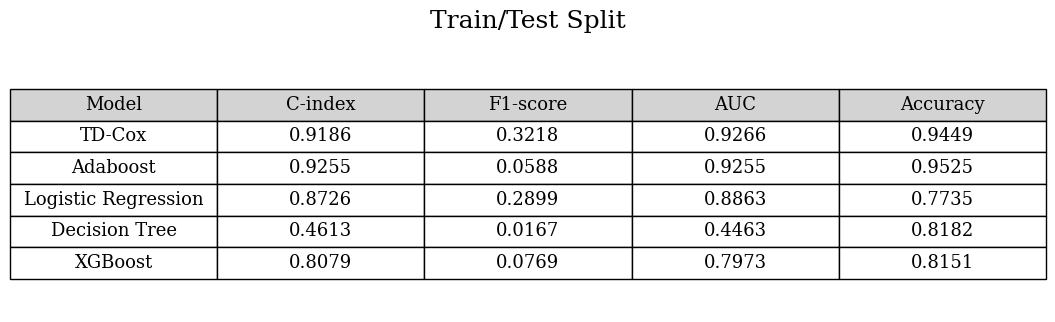

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# 대체 가능한 serif 계열 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Serif'  # Colab 기본 내장 serif 계열
# ✅ Train/Test Split 데이터
split_data = {
    'Model': ['TD-Cox', 'Adaboost', 'Logistic Regression', 'Decision Tree', 'XGBoost'],
    'C-index': [0.9186, 0.9255, 0.8726, 0.4613, 0.8079],
    'F1-score': [0.3218, 0.0588, 0.2899, 0.0167, 0.0769],
    'AUC': [0.9266, 0.9255, 0.8863, 0.4463, 0.7973],
    'Accuracy': [0.9449, 0.9525, 0.7735, 0.8182, 0.8151]
}
split_df = pd.DataFrame(split_data)

# ✅ 시각화
fig, ax = plt.subplots(figsize=(13, 3.5))
ax.axis('off')

tbl = plt.table(
    cellText=split_df.values,
    colLabels=split_df.columns,
    cellLoc='center',
    loc='center',
    rowLabels=None,
    colColours=["lightgray"] * split_df.shape[1]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(13)         # ✅ 폰트 크기 업
tbl.scale(1.6, 2.0)          # ✅ 셀 가로/세로 간격 업

plt.title(" Train/Test Split ", fontsize=18, pad=20)
plt.tight_layout()
plt.show()


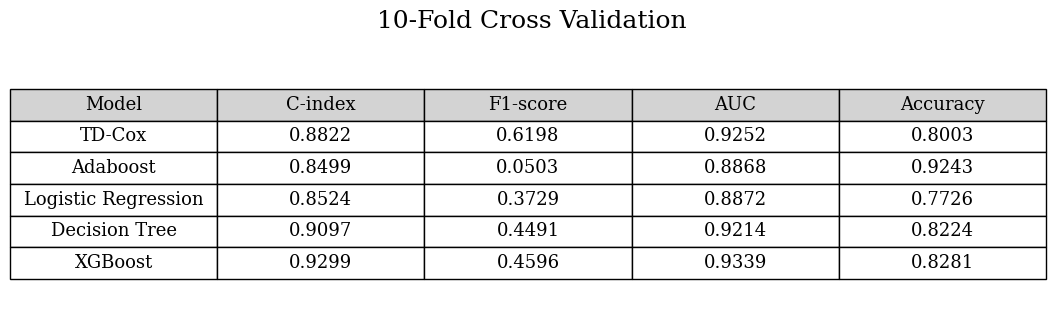

In [ ]:
# ✅ 10-Fold CV 데이터
cv_data = {
    'Model': ['TD-Cox', 'Adaboost', 'Logistic Regression', 'Decision Tree', 'XGBoost'],
    'C-index': [0.8822, 0.8499, 0.8524, 0.9097, 0.9299],
    'F1-score': [0.6198, 0.0503, 0.3729, 0.4491, 0.4596],
    'AUC': [0.9252, 0.8868, 0.8872, 0.9214, 0.9339],
    'Accuracy': [0.8003, 0.9243, 0.7726, 0.8224, 0.8281]
}
cv_df = pd.DataFrame(cv_data)
plt.rcParams['font.family'] = 'DejaVu Serif'
# ✅ 시각화
fig, ax = plt.subplots(figsize=(13, 3.5))
ax.axis('off')

tbl = plt.table(
    cellText=cv_df.values,
    colLabels=cv_df.columns,
    cellLoc='center',
    loc='center',
    rowLabels=None,
    colColours=["lightgray"] * cv_df.shape[1]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(13)         # ✅ 폰트 크기 업
tbl.scale(1.6, 2.0)          # ✅ 셀 가로/세로 간격 업

plt.title(" 10-Fold Cross Validation", fontsize=18, pad=20)
plt.tight_layout()
plt.show()
